In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
import tifffile
import pre_process_mm as pre
import mm3_adapted_cell_segmentation as mm3seg
import mm3_adapted_cell_tracking as mm3track
import plot_cells
import growth_curves
from skimage.draw import polygon
from skimage import measure
from skimage.measure import regionprops, label
from skimage.io import imread

In [13]:
def _create_kymograph(phase_stack, start, end, fov_id, peak_id, output_dir):
    """Creates and saves a kymograph."""
    kymographs_gray = []
    for i in range(start, end):
        phase = phase_stack[i]
        if phase.ndim == 3:
            kymographs_gray.append(np.mean(phase, axis=2))
        else:
            kymographs_gray.append(phase)

    combined_kymograph = np.concatenate(kymographs_gray, axis=1)
    lin_filename = f'{fov_id}_{peak_id}.tif'
    lin_filepath = os.path.join(output_dir, lin_filename)  # Use output_dir
    tifffile.imwrite(lin_filepath, combined_kymograph)

In [17]:
# select cells starting at t= 28 for fov 005
lineage_FOV_dict = {'DUMM_giTG62_Glucose_012925': 
            {'005': ['445', '900', '1128', '1277', '1887',  '2115', '2344', '2421', '2497']
         }
           }
test_lineage_FOV_dict = {'DUMM_giTG62_Glucose_012925': 
            {'005': ['445']}}

In [18]:
# stich together all timepoints into a kymograph
phase_channel = '0'
fluor_channel = '1'
start = 28
end = 175
for folder, fov_dict in lineage_FOV_dict.items():
    for fov_id in fov_dict.keys():
        ana_peak_ids = fov_dict[fov_id]
        for peak_id in ana_peak_ids:
            path_to_phase_stack = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{folder}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/subtracted_FOV_{fov_id}_region_{peak_id}_c_{phase_channel}.tif'
            path_to_fluor_stack = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{folder}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/subtracted_FOV_{fov_id}_region_{peak_id}_c_{fluor_channel}.tif'
            path_to_labeled_stack = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{folder}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/mm3_segmented_subtracted_FOV_{fov_id}_region_{peak_id}_c_{phase_channel}.tif'
            phase_stack = tifffile.imread(path_to_phase_stack)
            labeled_stack = tifffile.imread(path_to_labeled_stack)
            phase_output_dir = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{folder}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted'
            _create_kymograph(phase_stack, start, end, fov_id, peak_id, phase_output_dir)
            mask_output_dir = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{folder}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/mask'
            os.makedirs(mask_output_dir, exist_ok=True)
            _create_kymograph(labeled_stack, start, end, fov_id, peak_id, mask_output_dir)

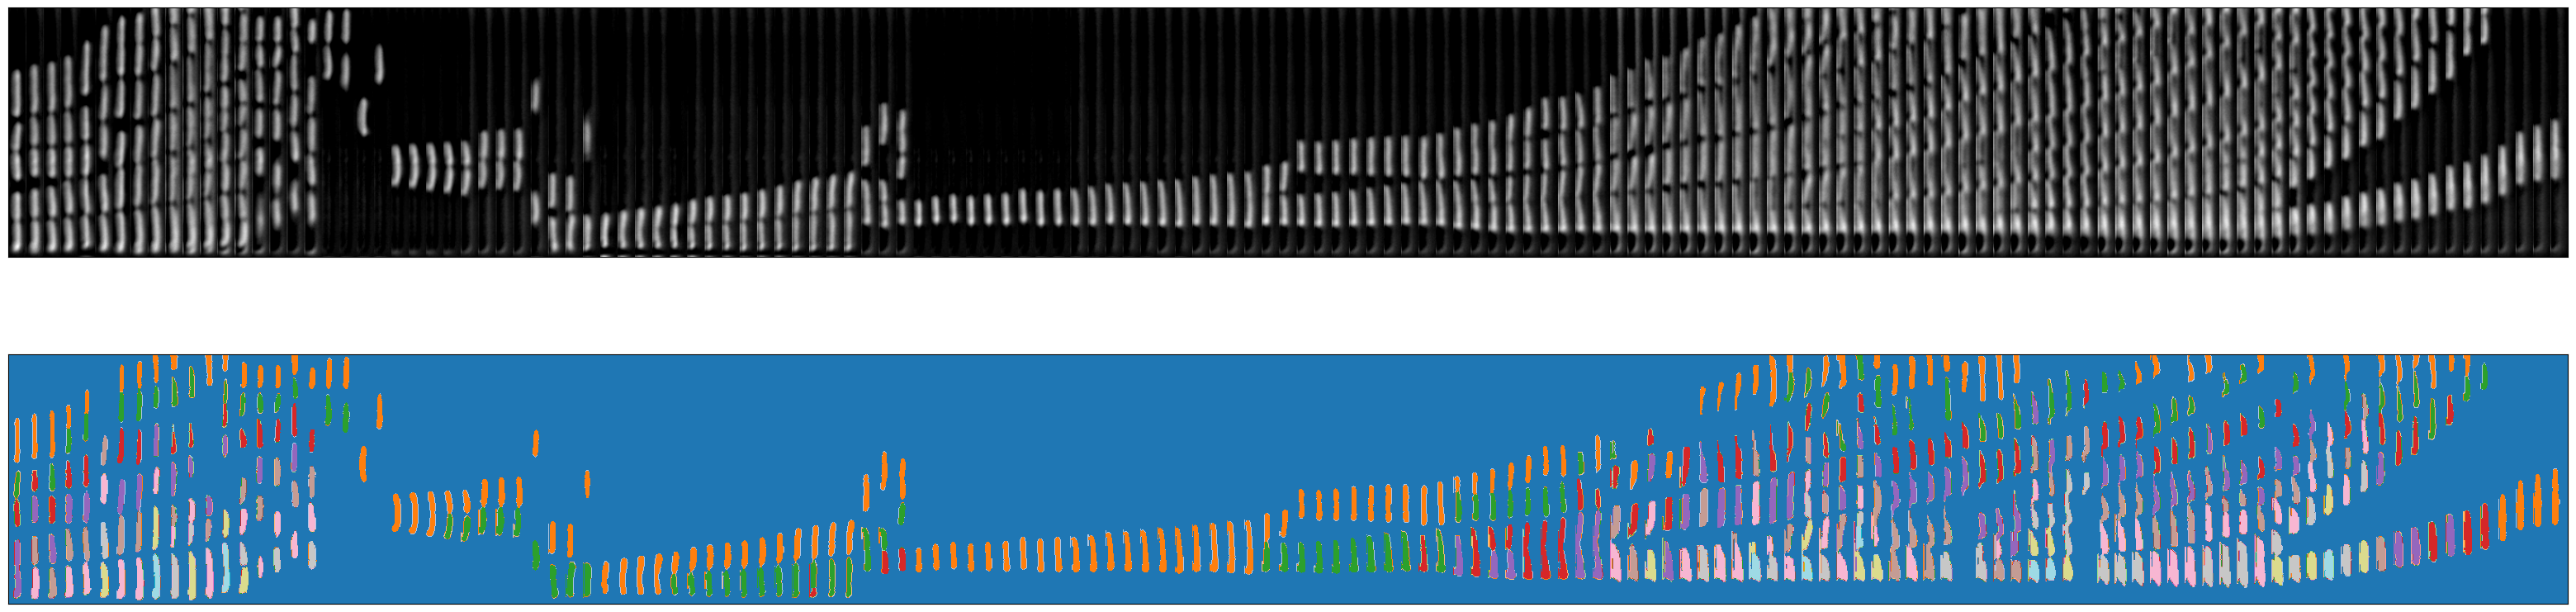

In [19]:
for folder, fov_dict in test_lineage_FOV_dict.items():
    for fov_id in fov_dict.keys():
        ana_peak_ids = fov_dict[fov_id]
        for peak_id in ana_peak_ids:
            phase_output_dir = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{folder}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted'
            mask_output_dir = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{folder}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/mask'
            kymograph_filename = f'{fov_id}_{peak_id}.tif'
            phase_kymograph_filepath = os.path.join(phase_output_dir, kymograph_filename)
            mask_kymograph_filepath = os.path.join(mask_output_dir, kymograph_filename)
            phase_kymograph = tifffile.imread(phase_kymograph_filepath)
            mask_kymograph = tifffile.imread(mask_kymograph_filepath)
            fig, ax = plt.subplots(2,1, figsize=(40, 10))
            ax[0].imshow(phase_kymograph, cmap = 'grey')
            ax[0].set_yticks([])
            ax[0].set_xticks([])
            ax[1].imshow(mask_kymograph, cmap = 'tab20')
            ax[1].set_yticks([])
            ax[1].set_xticks([])

In [20]:
# Label all the connected regions in the entire stitched mask
labeled_kymograph_mask = label(mask_kymograph)

In [27]:
props = measure.regionprops_table(labeled_kymograph_mask, phase_kymograph,
                          properties=['label', 'area', 'coords', 'centroid', 'axis_major_length', 'axis_minor_length',
                                      'intensity_mean'])

In [29]:
region_df = pd.DataFrame(props) 

# from the labeled stack shape I know I have 180 timepoints but I specified a specific range of 28-175, but anyways, if I know my stack dimensions of 288 pixels on y axis and 20 pixels of x axis, I can use these values to estimate timeframe

In [40]:
mask_kymograph.shape[-1]/labeled_stack.shape[-1]

147.0

In [44]:
enumerated_x_increments_dict = {index: value for index, value in enumerate(list(range(labeled_stack.shape[-1], mask_kymograph.shape[-1]+1, labeled_stack.shape[-1])))}

In [74]:
time_frame_pixel_dict = {}
for time_frame, x_limit in enumerated_x_increments_dict.items():
    time_frame_pixel_dict[time_frame] = (x_limit-labeled_stack.shape[-1], x_limit-1)

In [76]:
def map_pixel_to_index(pixel, range_dict):
    for index, (min_val, max_val) in range_dict.items():
        if min_val <= pixel <= max_val:
            return index
    return None

In [77]:
#now I will map the x coordinates based on these ranges
region_df['time_frame'] = region_df['centroid-1'].apply(map_pixel_to_index, range_dict=time_frame_pixel_dict)

In [82]:
region_df.head(5)

,label,area,coords,centroid-0,centroid-1,axis_major_length,axis_minor_length,intensity_mean,time_frame
0,1,182.0,"[[0, 166], [0, 167], [0, 168], [0, 169], [0, 1...",14.615385,169.423077,37.096642,6.667422,8683.736264,8
1,2,125.0,"[[0, 187], [0, 188], [0, 189], [0, 190], [0, 1...",8.016000,189.984000,20.421963,8.218469,8732.856000,9
2,3,233.0,"[[0, 226], [0, 227], [0, 228], [0, 229], [0, 2...",16.566524,230.412017,42.404185,7.669648,8531.793991,11
3,4,115.0,"[[0, 246], [0, 247], [0, 248], [0, 249], [0, 2...",8.626087,248.843478,22.527732,6.982785,8920.156522,12
4,5,165.0,"[[0, 325], [0, 326], [0, 327], [0, 328], [0, 3...",10.478788,328.666667,26.321368,8.304471,8684.884848,16


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_80746/3286174236.py:12: UserWarning: The following kwargs were not used by contour: 'color'
  ax.contour(cell_mask, levels=[0.5], color = 'red', linewidths=1)


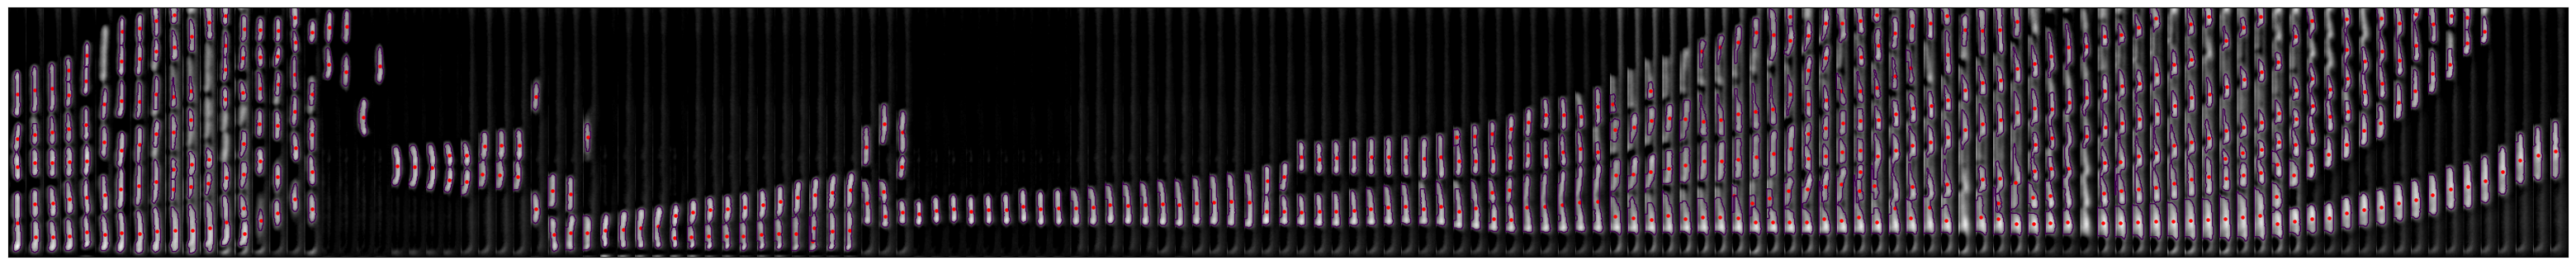

In [83]:
fig, ax = plt.subplots(1,1, figsize=(40, 10))
ax.imshow(phase_kymograph, cmap = 'grey')
for index, region_props in region_df.iterrows():
    coords = region_props['coords']
    y_coord = region_props['centroid-0']
    x_coord = region_props['centroid-1']
    
    cell_mask = np.zeros(phase_kymograph.shape, dtype=int)
    rr, cc = polygon(np.array(coords)[:, 0],  np.array(coords)[:, 1], phase_kymograph.shape)
    cell_mask[rr, cc] = 1
    
    ax.contour(cell_mask, levels=[0.5], color = 'red', linewidths=1)

    ax.scatter(x_coord,y_coord, color = 'red', s = 5)
ax.set_yticks([]);
ax.set_xticks([]);

In [88]:
from scipy.optimize import curve_fit
from scipy.spatial.distance import euclidean
import networkx as nx

In [121]:
def link_cells_graph_based(df, max_distance_y=5, max_diff_area_ratio=0.5, area_weight_factor=0.1,  preference_upward_shift=0.5):
    """
    Links cells across multiple frames using a graph-based approach.

    Args:
        df (pd.DataFrame): DataFrame with region properties, including
                           'frame', 'label', 'centroid', 'area'.
        max_distance_centroid (float): Maximum allowed Euclidean distance
                                       between centroids in consecutive frames
                                       to consider a potential link.
        max_diff_area_ratio (float): Maximum allowed ratio of the absolute
                                     difference in area to the average area
                                     to consider a potential link.

    Returns:
        pd.DataFrame: DataFrame with an added 'track_id' column indicating the
                      linked cell track ID.
    """
    if 'time_frame' not in df.columns:
        raise ValueError("DataFrame must have a 'frame' column.")

    unique_frames = sorted(df['time_frame'].unique())
    graph = nx.DiGraph()
    node_id_counter = 0
    node_map = {}  # (frame, label) -> node_id

    # Add nodes for each detection
    for frame in unique_frames:
        frame_df = df[df['time_frame'] == frame].copy()
        for index, row in frame_df.iterrows():
            node_id = node_id_counter
            graph.add_node(node_id, frame=row['time_frame'], label=row['label'],
                           centroid=row['centroid-0'], area=row['area'])
            node_map[(row['time_frame'], row['label'])] = node_id
            node_id_counter += 1

    # Add edges between potential links in consecutive frames
    for i in range(len(unique_frames) - 1):
        current_frame = unique_frames[i]
        next_frame = unique_frames[i + 1]

        current_frame_df = df[df['time_frame'] == current_frame]
        next_frame_df = df[df['time_frame'] == next_frame]

        for _, current_row in current_frame_df.iterrows():
            current_centroid_y = current_row['centroid-0']
            current_area = current_row['area']
            current_node_id = node_map[(current_row['time_frame'], current_row['label'])]

            for _, next_row in next_frame_df.iterrows():
                next_centroid_y = next_row['centroid-0']
                next_area = next_row['area']
                next_node_id = node_map[(next_row['time_frame'], next_row['label'])]

                y_distance = abs(current_centroid_y - next_centroid_y)
                avg_area = (current_area + next_area) / 2
                diff_area_ratio = abs(current_area - next_area) / avg_area if avg_area > 0 else 0

                if y_distance <= max_distance_y and diff_area_ratio <= max_diff_area_ratio:
                    # Add an edge with a weight representing the "cost" of the link
                    # Lower weight means a more likely link
                    weight = y_distance + area_weight_factor * diff_area_ratio
                    # Apply preference for upward shift (smaller y in next frame)
                    if next_centroid_y <= current_centroid_y:
                        weight *= (1 - preference_upward_shift)
                    graph.add_edge(current_node_id, next_node_id, weight=weight)

    # Find tracks as paths through the graph
    tracks = []
    visited_nodes = set()

    for node_id in graph.nodes():
        if node_id not in visited_nodes and not list(graph.predecessors(node_id)):
            # Start a new track from a node with no predecessors
            current_track = [node_id]
            current_node = node_id
            visited_nodes.add(node_id)

            while True:
                successors = list(graph.successors(current_node))
                if not successors:
                    break

                # For simplicity, choose the successor with the minimum weight edge
                best_successor = None
                min_weight = float('inf')
                for successor in successors:
                    weight = graph.get_edge_data(current_node, successor)['weight']
                    if weight < min_weight:
                        min_weight = weight
                        best_successor = successor

                if best_successor is not None:
                    current_track.append(best_successor)
                    visited_nodes.add(best_successor)
                    current_node = best_successor
                else:
                    break
            if current_track:
                tracks.append(current_track)

    # Assign track IDs back to the DataFrame
    df['track_id'] = np.nan
    track_id_counter = 1
    for track in tracks:
        for node_id in track:
            node_info = graph.nodes[node_id]
            frame = node_info['frame']
            label = node_info['label']
            df.loc[(df['time_frame'] == frame) & (df['label'] == label), 'track_id'] = track_id_counter
        track_id_counter += 1

    return df

In [126]:
import random

def plot_tracks_on_kymograph(phase_kymograph, region_df, track_id_col='track_id'):
    """
    Plots the kymograph with cell contours and overlays track IDs.

    Args:
        phase_kymograph (np.ndarray): The kymograph image.
        region_df (pd.DataFrame): DataFrame with region properties, including
                                   'coords', 'centroid-0', 'centroid-1', and
                                   the track ID column (default 'track_id').
        track_id_col (str): Name of the column containing the track IDs.
    """
    fig, ax = plt.subplots(1, 1, figsize=(40, 10))
    ax.imshow(phase_kymograph, cmap='grey')

    # Create a dictionary to map track IDs to colors
    unique_track_ids = region_df[track_id_col].dropna().unique()
    track_colors = {track_id: (random.random(), random.random(), random.random())
                    for track_id in unique_track_ids}

    for index, region_props in region_df.iterrows():
        coords = region_props['coords']
        y_coord = region_props['centroid-0']
        x_coord = region_props['centroid-1']
        track_id = region_props.get(track_id_col)

        cell_mask = np.zeros(phase_kymograph.shape, dtype=int)
        rr, cc = polygon(np.array(coords)[:, 0], np.array(coords)[:, 1], phase_kymograph.shape)
        cell_mask[rr, cc] = 1

        color = 'red'  # Default color if track_id is NaN or not in the map
        if pd.notna(track_id) and track_id in track_colors:
            color = track_colors[track_id]

        ax.contour(cell_mask, levels=[0.5], color=color, linewidths=1)
        ax.scatter(x_coord, y_coord, color=color, s=5)

        # Add track ID text near the centroid
        if pd.notna(track_id):
            ax.text(x_coord + 2, y_coord - 2, f'{int(track_id)}', color='white', fontsize=8, ha='left', va='top')

    ax.set_yticks([])
    ax.set_xticks([])
    plt.title("Kymograph with Cell Contours and Track IDs")
    plt.ylabel("Spatial Dimension")
    plt.xlabel("Time (Frame)")
    plt.show()

In [128]:
if __name__ == '__main__':
    # Link the cells using the graph-based method
    linked_df = link_cells_graph_based(region_df.copy(), preference_upward_shift=0.2)

/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_80746/2580756158.py:36: UserWarning: The following kwargs were not used by contour: 'color'
  ax.contour(cell_mask, levels=[0.5], color=color, linewidths=1)


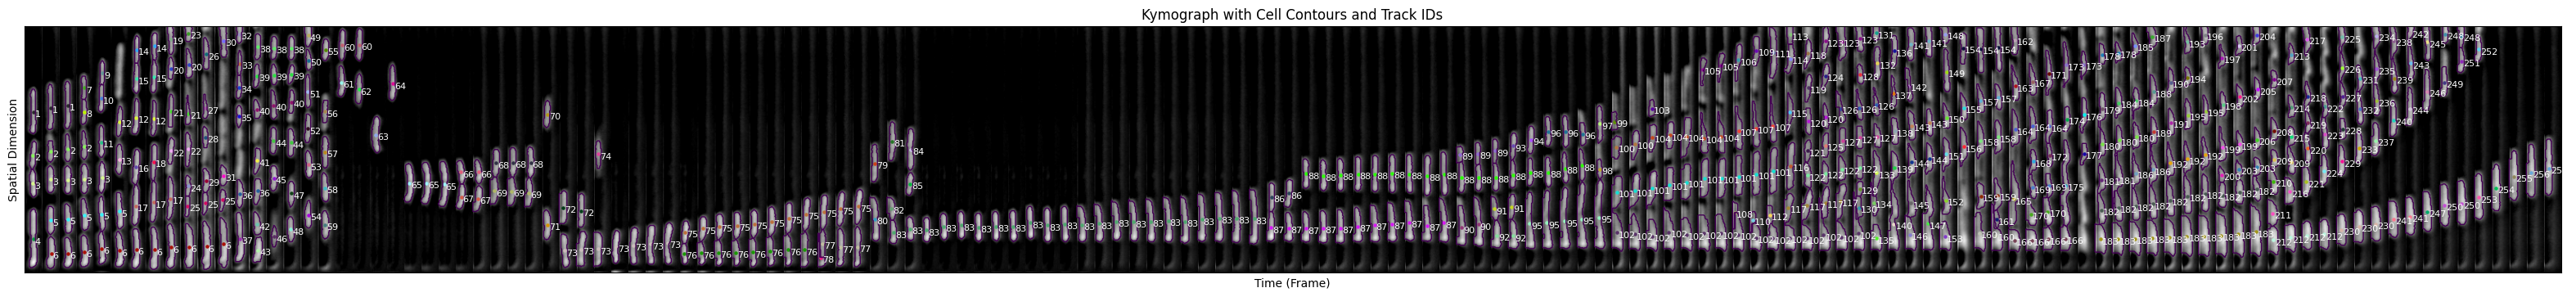

In [129]:
plot_tracks_on_kymograph(phase_kymograph, linked_df, track_id_col='track_id')